# Import Required Libraries
Import libraries such as `matplotlib` for visualization.

In [1]:
import matplotlib.pyplot as plt  # For data visualization
import numpy as np  # For numerical operations

# Load Preprocessed Files

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_emg_ref_overlay(path, fs=None, combine='mean', method='zscore'):
    """
    path: .npy/.npz file that contains:
          {'data': (C,T) EMG, 'ref_signal': (T,), ...}
    fs:   optional sampling rate (Hz) to show seconds on x-axis
    combine: 'mean' | 'rms' | int (channel index)  -> make 1D EMG trace
    method: 'zscore' (overlay on one axis) | 'twin' (two y-axes)
    """
    obj = np.load(path, allow_pickle=True)
    d = obj.item() if hasattr(obj, "item") else obj  # your file is array({..}, dtype=object)

    D   = np.asarray(d['data'])           # (C, T)
    ref = np.asarray(d['ref_signal']).squeeze()  # (T,)

    # align lengths
    T = min(D.shape[1], ref.shape[0])
    D, ref = D[:, :T], ref[:T]

    # make a single EMG trace
    if combine == 'mean':
        emg = D.mean(axis=0)
    elif combine == 'rms':
        emg = np.sqrt((D**2).mean(axis=0))
    elif isinstance(combine, int):
        emg = D[combine]
    else:
        raise ValueError("combine must be 'mean', 'rms', or an int channel index")

    # x-axis
    x = np.arange(T)/fs if fs else np.arange(T)
    xlabel = "Time (s)" if fs else "Sample"

    if method == 'zscore':
        # normalize both to compare on same axis
        def z(x):
            s = x.std()
            return (x - x.mean()) / (s if s > 0 else 1.0)
        emg_p = z(emg); ref_p = z(ref)

        plt.figure(figsize=(12, 4))
        plt.plot(x, emg_p, label='EMG (z-score)', lw=1)
        plt.plot(x, ref_p, label='ref_signal (z-score)', lw=1, alpha=0.85)
        plt.xlabel(xlabel); plt.ylabel("z-score"); plt.grid(True, alpha=0.3)
        title = f"Overlay (C={D.shape[0]}, T={T})"
        if 'region_num' in d: title += f" • Region {d['region_num']}"
        plt.title(title)
        plt.legend()
        plt.tight_layout(); plt.show()

    elif method == 'twin':
        fig, ax1 = plt.subplots(figsize=(12, 4))
        l1, = ax1.plot(x, emg, lw=1, label='EMG')
        ax1.set_xlabel(xlabel); ax1.set_ylabel('EMG'); ax1.grid(True, alpha=0.3)

        ax2 = ax1.twinx()
        l2, = ax2.plot(x, ref, lw=1, alpha=0.85, label='ref_signal', color='C1')
        ax2.set_ylabel('ref_signal')

        lines = [l1, l2]
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper right')

        title = f"Overlay (C={D.shape[0]}, T={T})"
        if 'region_num' in d: title += f" • Region {d['region_num']}"
        ax1.set_title(title)
        fig.tight_layout(); plt.show()
    else:
        raise ValueError("method must be 'zscore' or 'twin'")


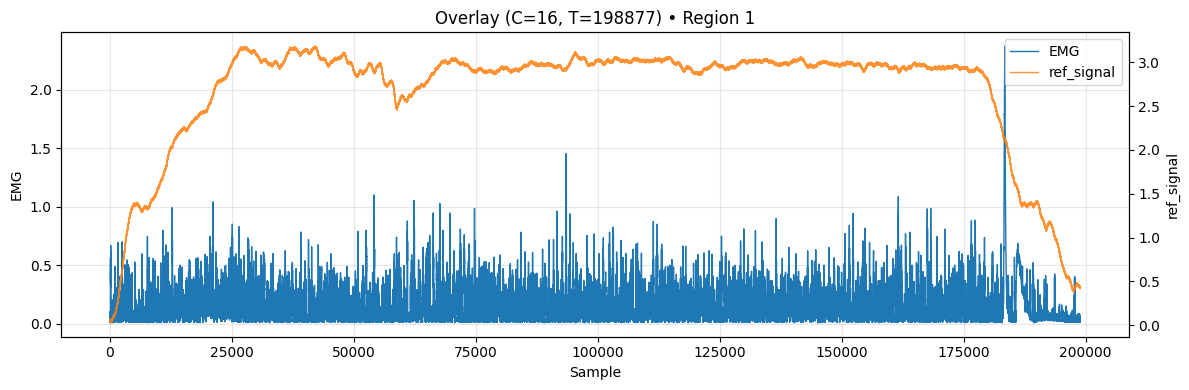

In [16]:
# Simple: same-axis overlay via z-score
plot_emg_ref_overlay("data/preprocessing/P5_prp/90_F1_1.npy", fs=None, combine='rms', method='twin')



## Extracting Features

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt

# -------------------- Loader (NumPy regions only) --------------------

def load_region_file(path):
    """
    Load your saved region file (.npy or .npz) and return a dict:
      {'data': (T,C), 'ref_signal': (T,), 'meta': {...}}
    Accepts (C,T) or (T,C) for 'data' and fixes orientation to (T,C).
    """
    obj = np.load(path, allow_pickle=True)
    d = obj.item() if hasattr(obj, "item") else obj  # supports array({..}, dtype=object) and npz

    # pull arrays
    emg = np.asarray(d['data'], dtype=float)
    ref = np.asarray(d['ref_signal'], dtype=float).squeeze()

    # orient EMG to (T,C)
    if emg.ndim != 2:
        raise ValueError("'data' must be 2D (C,T) or (T,C)")
    # heuristic: channels ≤ 64; time is the larger dimension
    if emg.shape[0] <= 64 and emg.shape[1] > emg.shape[0]:
        # currently (C,T) -> transpose to (T,C)
        emg = emg.T

    # length align
    T = min(emg.shape[0], ref.shape[0])
    emg = emg[:T, :]
    ref = ref[:T]

    meta = {k: d[k] for k in d.keys() if k not in ('data', 'ref_signal')}
    return {'data': emg, 'ref_signal': ref, 'meta': meta}

# -------------------- Binning & RMS (NumPy only) --------------------

def _bin_1d(x, bin_size):
    n = len(x)
    b = n // bin_size
    return x[:b*bin_size].reshape(b, bin_size)

def extract_features_np(region_dict, bin_size=1000, mode='rms_matrix', channels=None,
                        angle_deg=None, include_angle_target=False):
    """
    region_dict: {'data': (T,C), 'ref_signal': (T,)}
    Returns:
      X : features  (B,C) for 'rms_matrix', or (B,1) for collapsed modes
      y : targets   (B,) if angle_deg is None, else (B,2)[(+ angle col)]
      fs: dummy 1.0 (kept for API compatibility)
    """
    emg = np.asarray(region_dict['data'], dtype=float)          # (T,C)
    ref = np.asarray(region_dict['ref_signal'], dtype=float)    # (T,)
    T, C = emg.shape

    # bin EMG -> (B, bin, C)
    B = T // bin_size
    T_use = B * bin_size
    emg_use = emg[:T_use, :]
    ref_use = ref[:T_use]
    b_emg = emg_use.reshape(B, bin_size, C)

    # RMS across time within each bin -> (B, C)
    rms_per_ch = np.sqrt((b_emg**2).mean(axis=1))   # (B, C)

    # build X
    if mode == 'rms_matrix':
        X = rms_per_ch
    elif mode == 'all_channels':  # one scalar per bin via RMS across channels
        X = np.sqrt((rms_per_ch**2).mean(axis=1, keepdims=True))
    elif mode == 'average_channels':  # mean across channels
        X = rms_per_ch.mean(axis=1, keepdims=True)
    elif mode == 'single_channel':
        if channels is None or len(channels) == 0:
            raise ValueError("Provide channels=[idx] for single_channel")
        X = rms_per_ch[:, [channels[0]]]
    else:
        raise ValueError(f"Unknown mode: {mode}")

    # targets y
    if angle_deg is None:
        # simple bin-mean of force magnitude
        y = _bin_1d(ref_use, bin_size).mean(axis=1)
    else:
        theta = np.deg2rad(angle_deg)
        fx = ref_use * np.cos(theta)
        fy = ref_use * np.sin(theta)
        yx = _bin_1d(fx, bin_size).mean(axis=1)
        yy = _bin_1d(fy, bin_size).mean(axis=1)
        y = np.stack([yx, yy], axis=1)
        if include_angle_target:
            y = np.concatenate([y, np.full((B,1), float(angle_deg))], axis=1)

    fs = 1.0  # no real fs in region files; keep API
    return X, y, fs

# -------------------- Quick plotting --------------------

def plot_rms_and_ref(R_matrix, y, title="RMS per channel & binned ref"):
    """
    R_matrix: (B, C)   y: (B,) or (B,2)
    """
    B, C = R_matrix.shape
    t = np.arange(B)

    # top: RMS per channel
    plt.figure(figsize=(12, 5))
    ax1 = plt.subplot(2,1,1)
    for ch in range(C):
        ax1.plot(t, R_matrix[:, ch], lw=0.8, alpha=0.9)
    ax1.set_title(f"{title}  • bins={B}, channels={C}")
    ax1.set_ylabel("RMS"); ax1.grid(True, alpha=0.3)

    # bottom: ref (or its components)
    ax2 = plt.subplot(2,1,2, sharex=ax1)
    if y.ndim == 1:
        ax2.plot(t, y, lw=1.0, label='ref (bin-mean)')
    else:
        ax2.plot(t, y[:,0], lw=1.0, label='Fx (bin-mean)')
        ax2.plot(t, y[:,1], lw=1.0, label='Fy (bin-mean)')
        ax2.legend()
    ax2.set_xlabel("Bin index"); ax2.set_ylabel("Force"); ax2.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()


R_matrix shape: (198, 16) | y shape: (198,)


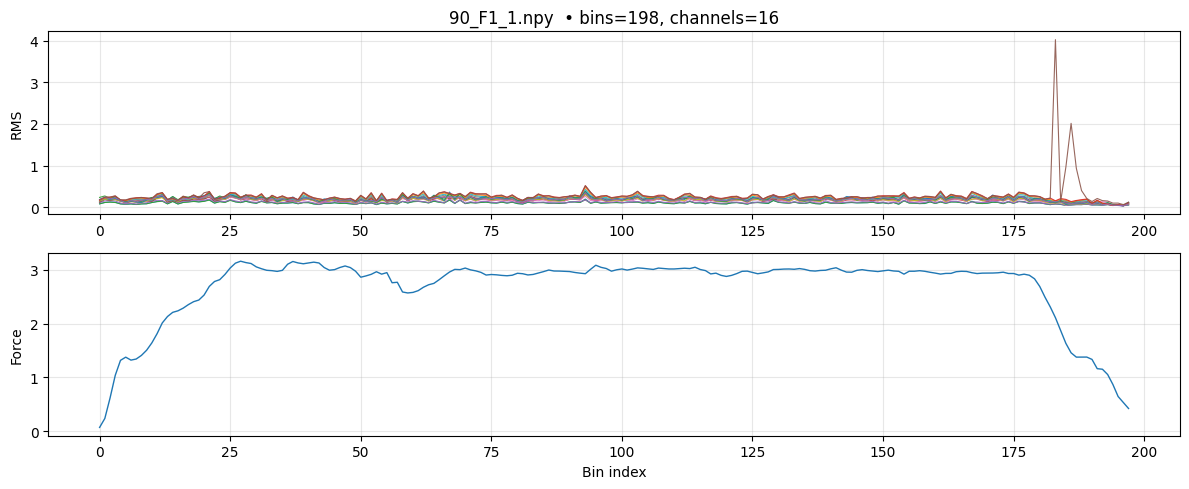

In [18]:
# point to your saved region .npy/.npz
PATH = "data/preprocessing/P5_prp/90_F1_1.npy"
BIN_SIZE = 1000

region = load_region_file(PATH)
R_matrix, y, _ = extract_features_np(region, bin_size=BIN_SIZE, mode='rms_matrix', angle_deg=None)

print("R_matrix shape:", R_matrix.shape, "| y shape:", y.shape)
plot_rms_and_ref(R_matrix, y, title=os.path.basename(PATH))


## Process all 

Found 14 files


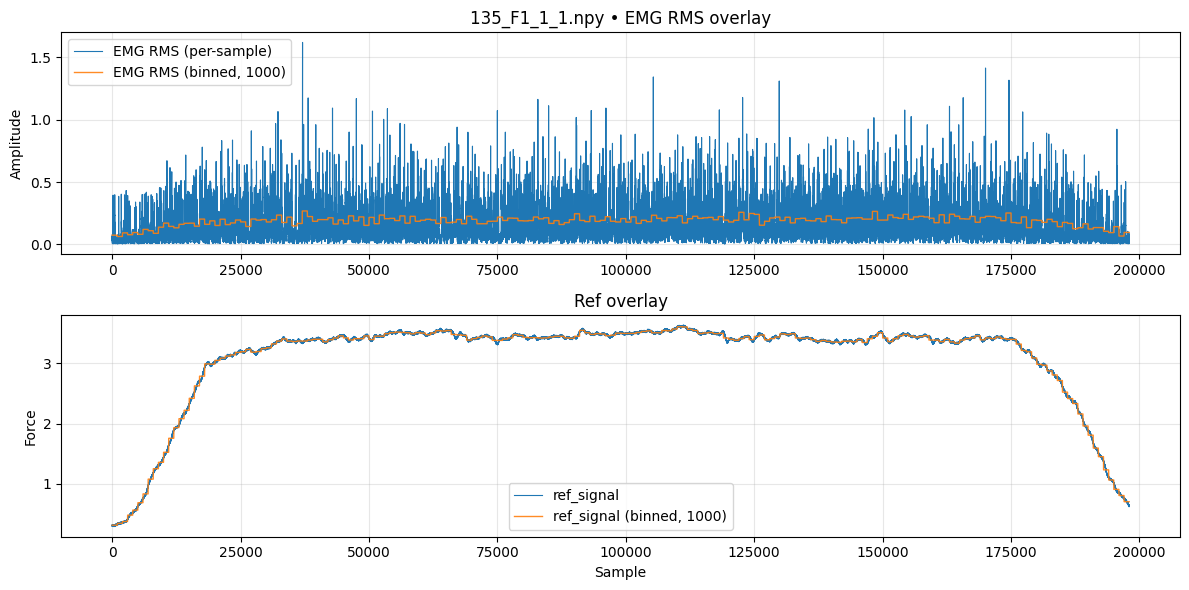

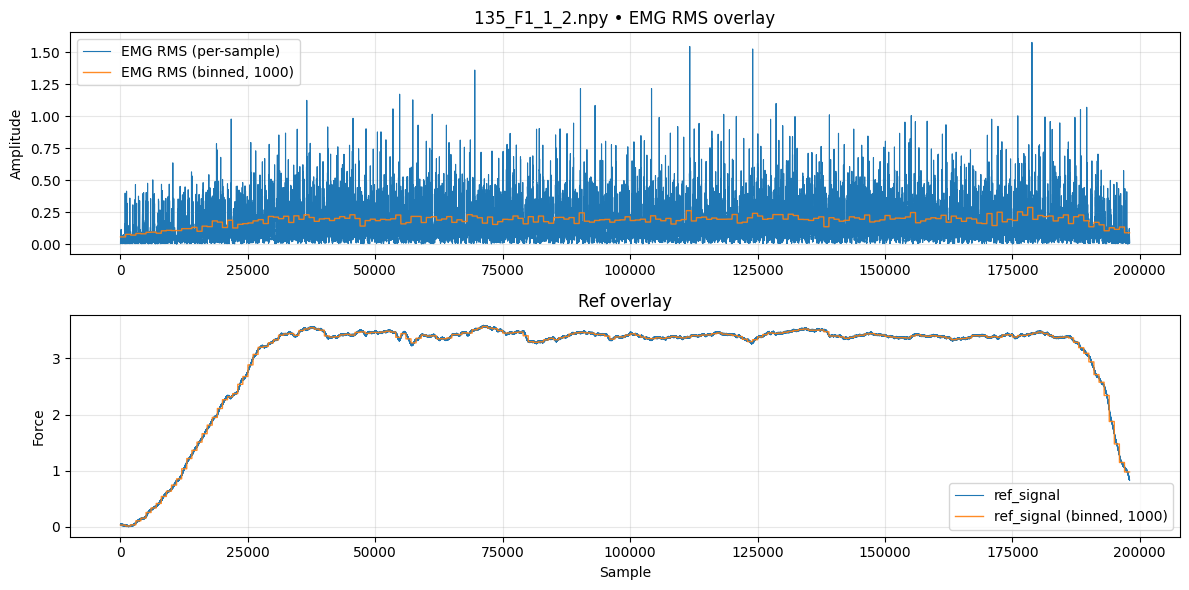

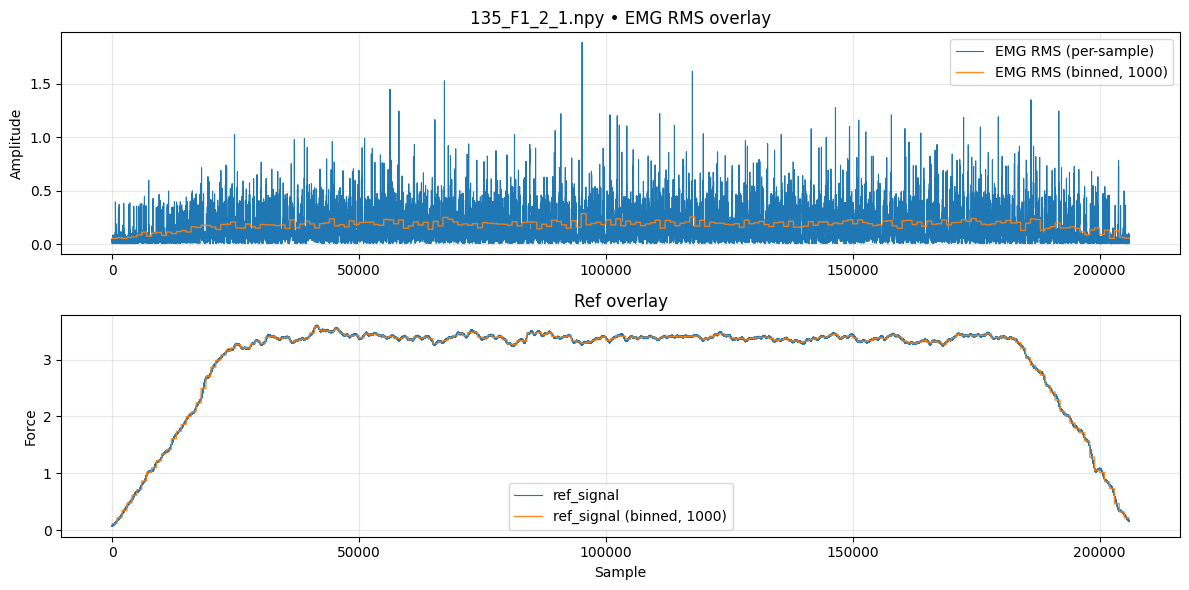

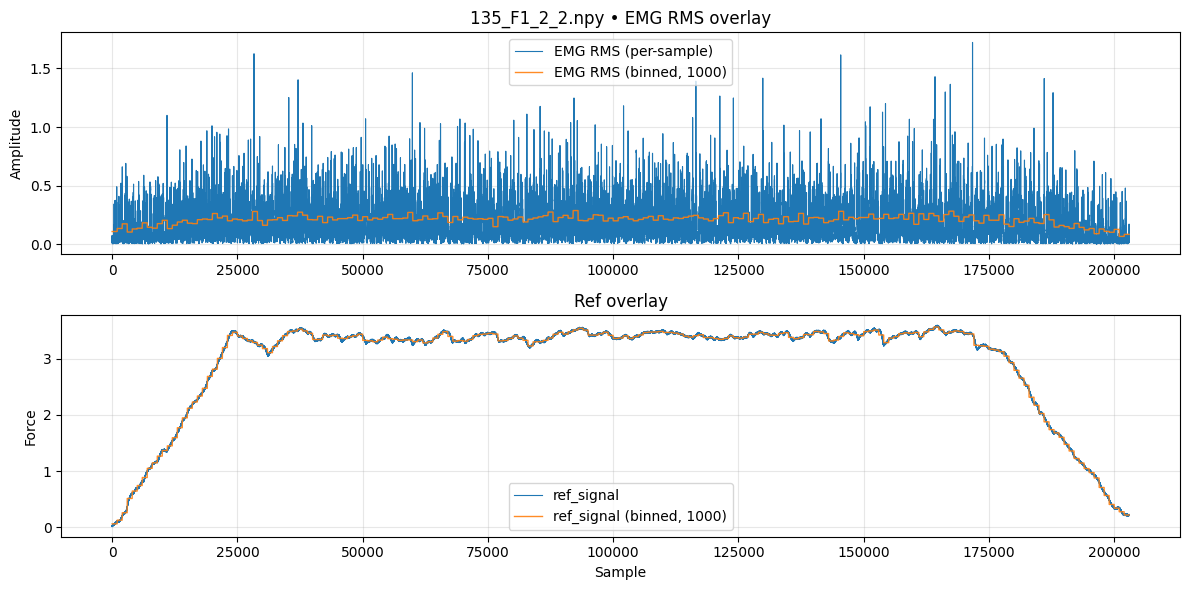

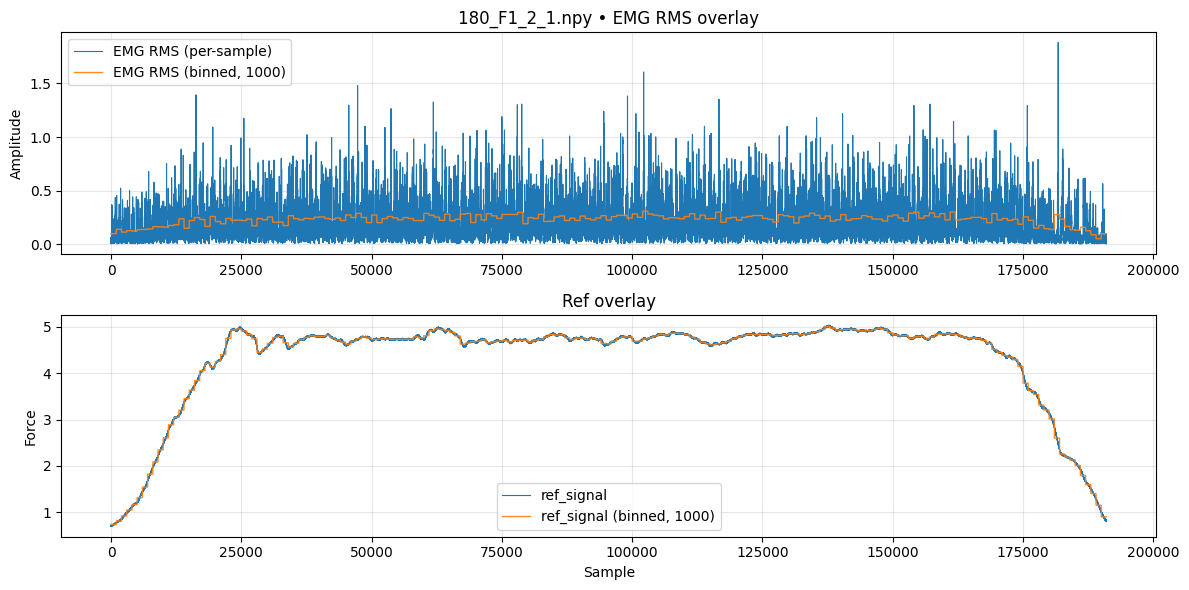

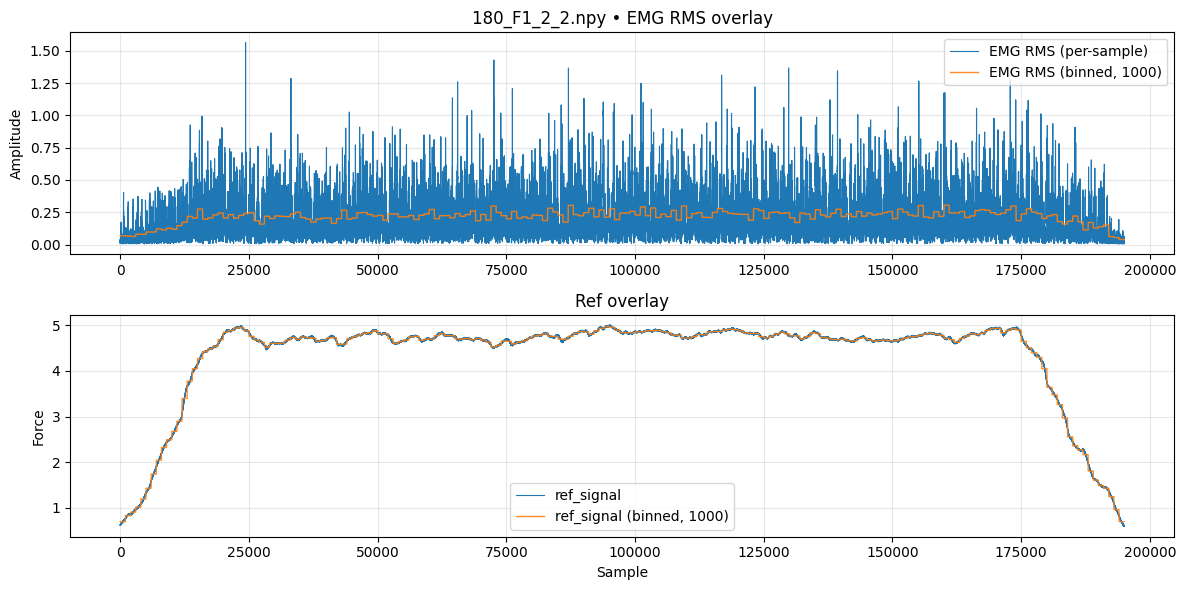

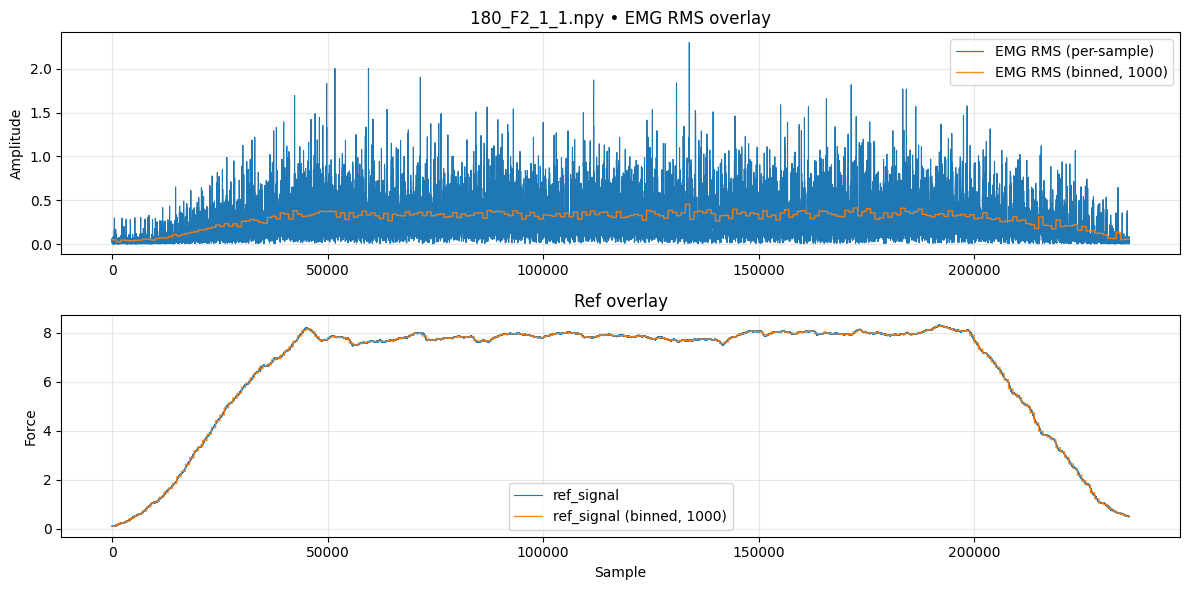

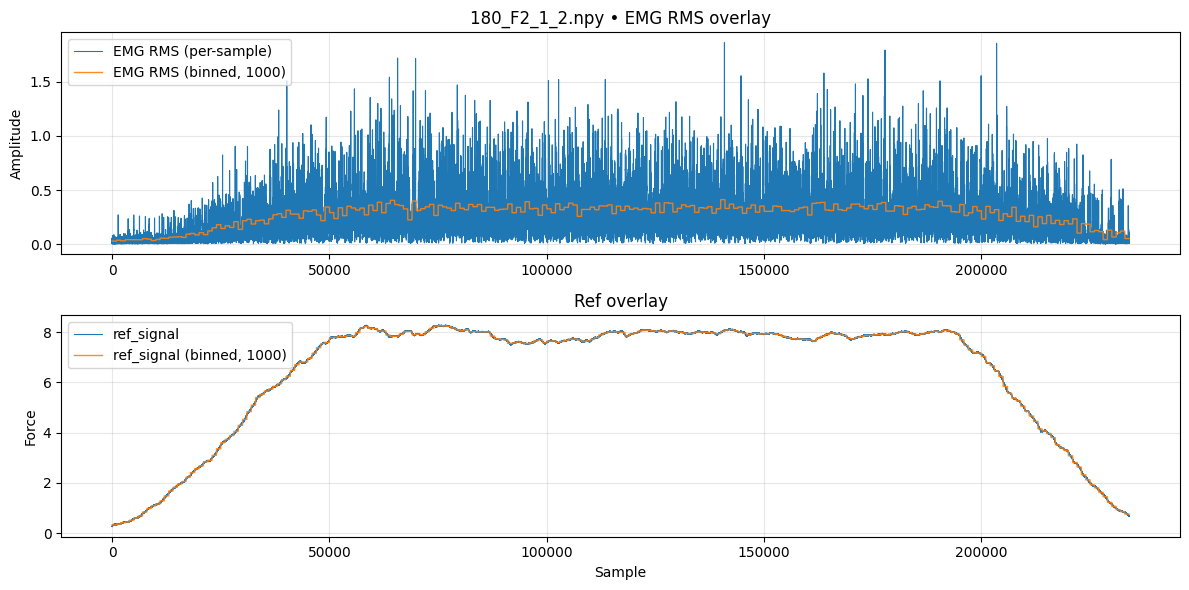

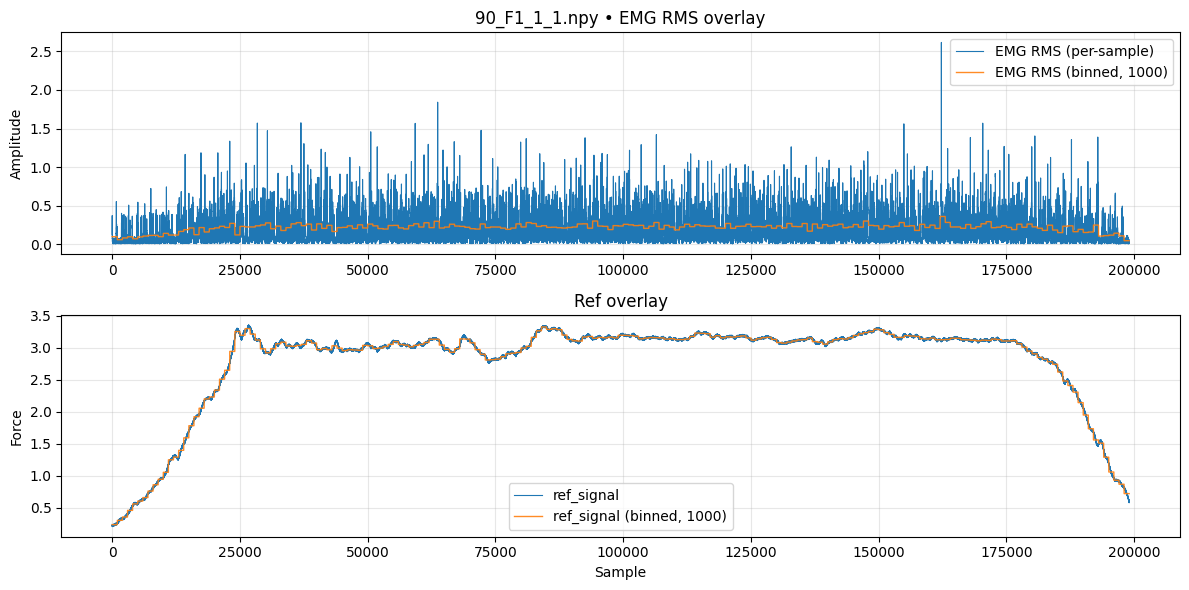

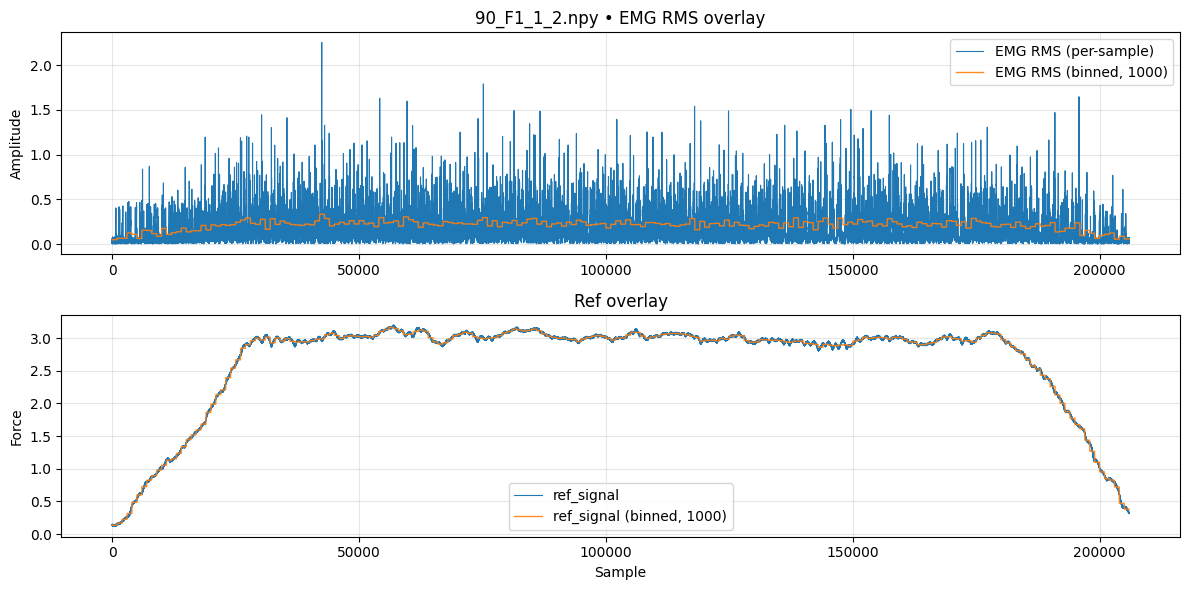

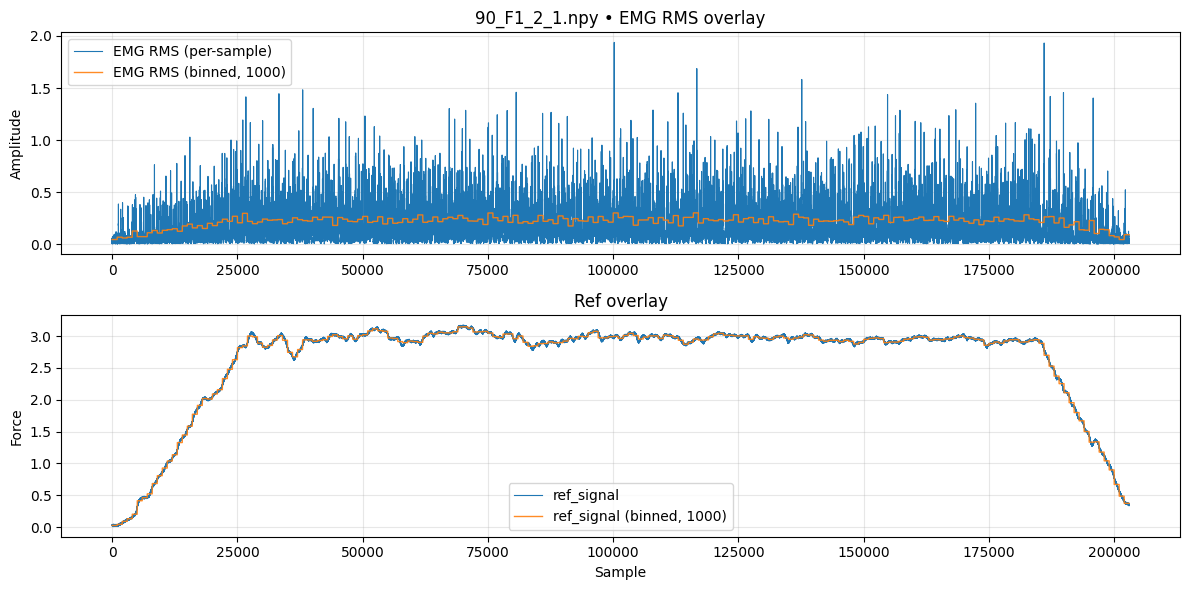

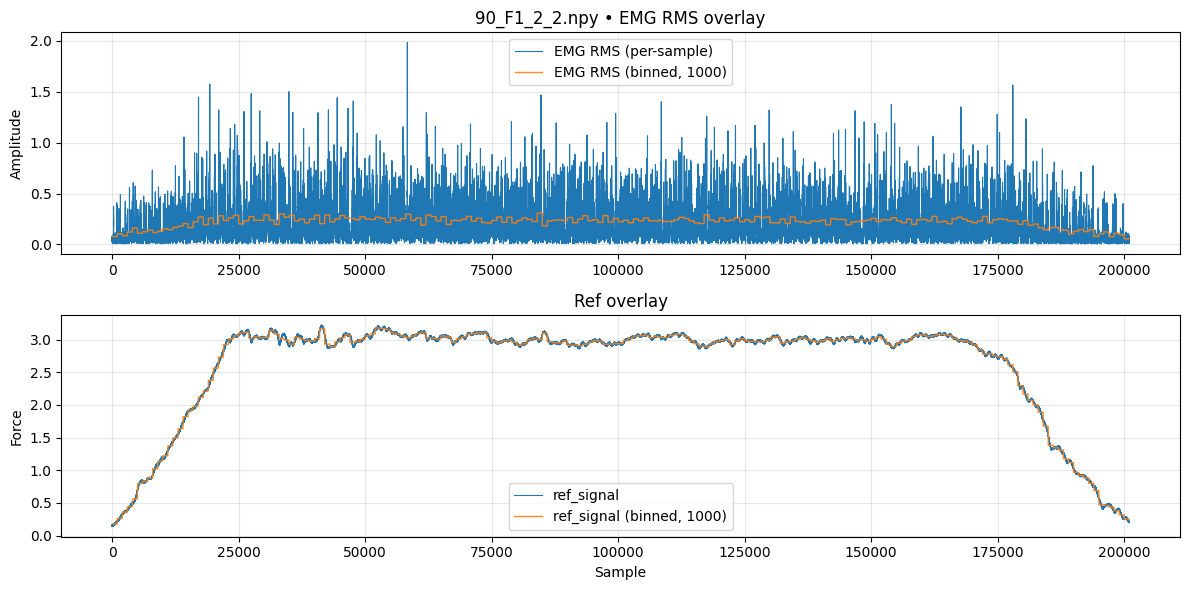

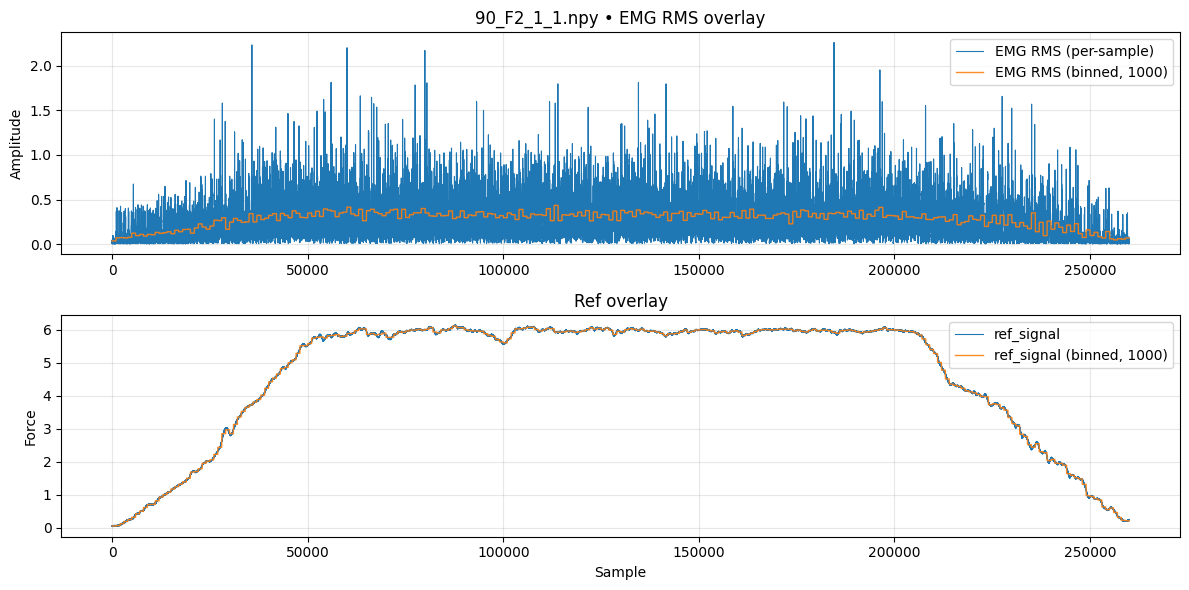

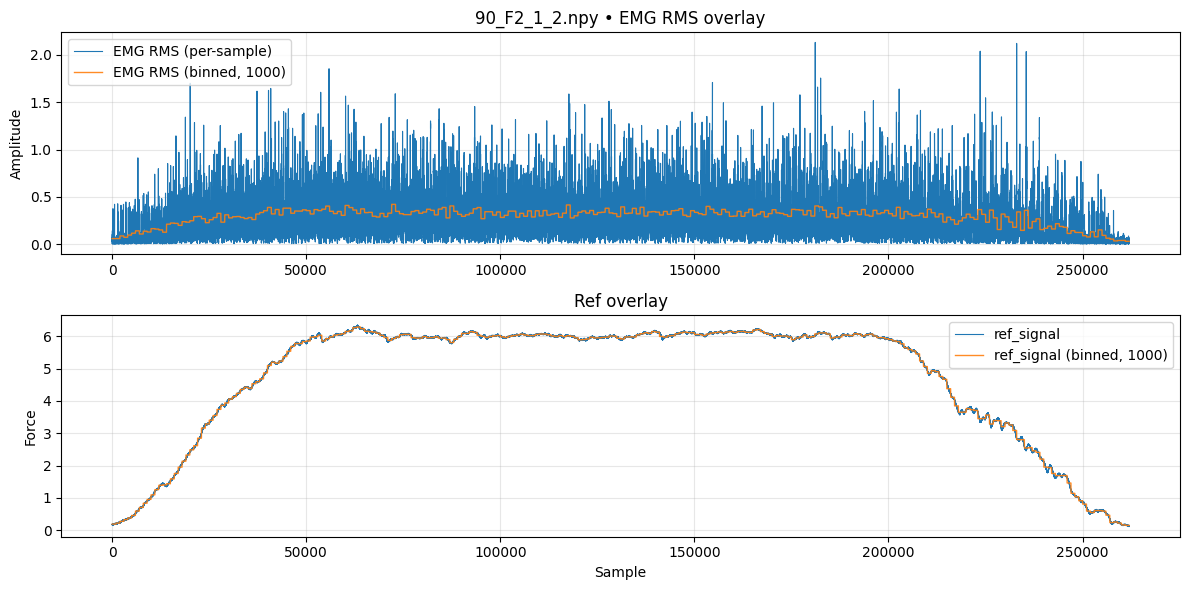

Done.


In [22]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt

FOLDER_IN  = "../data/preprocessing/P3_prp"
FOLDER_OUT = "../data/preprocessing/P3_prp_feat"   # keep originals untouched
BIN_SIZE   = 1000
os.makedirs(FOLDER_OUT, exist_ok=True)

def _load_region(path):
    obj = np.load(path, allow_pickle=True)
    d = obj.item() if hasattr(obj, "item") else obj
    D = np.asarray(d["data"], dtype=float)           # EMG
    ref = np.asarray(d["ref_signal"], dtype=float).squeeze()
    # Orient to (C, T)
    if D.ndim != 2:
        raise ValueError("'data' must be 2D.")
    if D.shape[0] > D.shape[1] and D.shape[1] <= 64:   # (T,C) → (C,T)
        D = D.T
    # Align lengths
    T = min(D.shape[1], ref.shape[0])
    return {"data": D[:, :T], "ref_signal": ref[:T], **{k: d[k] for k in d.keys() if k not in ("data","ref_signal")}}

def _rms_over_channels_per_sample(D_ct):
    # D_ct: (C,T) → (T,), RMS across channels at each sample
    return np.sqrt((D_ct**2).mean(axis=0))

def _bin_1d(x, bin_size):
    B = len(x) // bin_size
    return x[:B*bin_size].reshape(B, bin_size)

def _binned_features(D_ct, ref, bin_size):
    C, T = D_ct.shape
    B = T // bin_size
    T_use = B * bin_size
    # EMG: per-bin RMS per channel → (B,C)
    D_use = D_ct[:, :T_use].reshape(C, B, bin_size)
    rms_matrix = np.sqrt((D_use**2).mean(axis=2)).T          # (B,C)
    # collapse channels (RMS across channels) → (B,)
    emg_rms_binned = np.sqrt((rms_matrix**2).mean(axis=1))
    # REF: per-bin mean (or RMS if you prefer) → (B,)
    ref_binned = _bin_1d(ref[:T_use], bin_size).mean(axis=1)
    return rms_matrix, emg_rms_binned, ref_binned, T_use, B

def _plot_overlays(fname, emg_rms_sample, emg_rms_binned, ref, ref_binned, bin_size, T_use):
    # Upsample binned series to sample rate for visual overlay
    emg_binned_up = np.repeat(emg_rms_binned, bin_size)
    ref_binned_up = np.repeat(ref_binned, bin_size)
    t = np.arange(T_use); tb = np.arange(len(emg_rms_binned))

    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=False)
    # EMG overlay
    axes[0].plot(t, emg_rms_sample[:T_use], lw=0.8, label="EMG RMS (per-sample)")
    axes[0].plot(t, emg_binned_up, lw=1.0, alpha=0.9, label=f"EMG RMS (binned, {bin_size})")
    axes[0].set_title(f"{fname} • EMG RMS overlay"); axes[0].set_ylabel("Amplitude")
    axes[0].grid(True, alpha=0.3); axes[0].legend()
    # REF overlay
    axes[1].plot(t, ref[:T_use], lw=0.8, label="ref_signal")
    axes[1].plot(t, ref_binned_up, lw=1.0, alpha=0.9, label=f"ref_signal (binned, {bin_size})")
    axes[1].set_title("Ref overlay"); axes[1].set_xlabel("Sample"); axes[1].set_ylabel("Force")
    axes[1].grid(True, alpha=0.3); axes[1].legend()
    plt.tight_layout(); plt.show()

def process_folder(folder_in, folder_out, bin_size=1000, plot_checks=True):
    files = sorted(glob.glob(os.path.join(folder_in, "*.npy")) + glob.glob(os.path.join(folder_in, "*.npz")))
    print(f"Found {len(files)} files")

    for path in files:
        fname = os.path.basename(path)
        d = _load_region(path)
        D_ct = d["data"]          # (C,T)
        ref  = d["ref_signal"]    # (T,)

        # 1) per-sample RMS across channels (T,)
        emg_rms_sample = _rms_over_channels_per_sample(D_ct)

        # 2) binned features
        rms_matrix, emg_rms_binned, ref_binned, T_use, B = _binned_features(D_ct, ref, bin_size)

        # 3) attach features and save (to OUT folder)
        d_out = dict(d)  # copy
        d_out["emg_rms_per_sample"]    = emg_rms_sample                      # (T,)
        d_out["emg_rms_binned"]        = emg_rms_binned                      # (B,)
        d_out["emg_rms_matrix_binned"] = rms_matrix                          # (B,C)
        d_out["ref_binned"]            = ref_binned                          # (B,)
        d_out["bin_size"]              = int(bin_size)
        d_out["T_use_for_bins"]        = int(T_use)
        out_path = os.path.join(folder_out, fname)
        np.save(out_path, d_out, allow_pickle=True)

        # 4) quick visual check
        if plot_checks:
            _plot_overlays(fname, emg_rms_sample, emg_rms_binned, ref, ref_binned, bin_size, T_use)

    print("Done.")

# Run it
process_folder(FOLDER_IN, FOLDER_OUT, bin_size=BIN_SIZE, plot_checks=True)


In [4]:
from pathlib import Path
import numpy as np

PATIENT_FILE = Path("data/preprocessing/P1_prp_feat.npy")
BIN_SIZES = [500, 250]

def bin_signal(sig, bin_size):
    """Bin 1D signal and compute RMS per bin."""
    n_bins = len(sig) // bin_size
    sig = sig[:n_bins * bin_size]  # trim excess
    sig = sig.reshape(n_bins, bin_size)
    return np.sqrt(np.mean(sig**2, axis=1))

# --- Load existing npz ---
data_old = np.load(PATIENT_FILE, allow_pickle=True)
keys_old = list(data_old.keys())
print("Existing keys:", keys_old)

FileNotFoundError: [Errno 2] No such file or directory: 'data/preprocessing/P1_prp_feat.npy'